In [2]:
# Импортируем нужные библиотеки 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [3]:
# Читаем наш датасет 
df = pd.read_csv('people_data_clustering.csv')
print('Размеры',df.shape)
df.head()

Размеры (6000, 10)


,id,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
0,0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579


Чистка датасета (5 баллов)
1. Есть ли дубли в данных? Если есть удалить. 
2. Найти и удалить выбросы по признаку home_cost. (Их не больше 15-х, не меньше 3-х)

In [4]:
#1 Убираем дубли в данных (Размеры одинаковы)
df = df.drop_duplicates(keep=False)
print('Размеры',df.shape)

Размеры (6000, 10)


Используем метод IQR для выявления выбросов, чтобы установить «забор» за пределами Q1 и Q3. Любые значения, выходящие за пределы этой границы, считаются выбросами. Чтобы построить этот забор, мы берем IQR в 1,5 раза, затем вычитаем это значение из Q1 и добавляем это значение к Q3.

,id,was_married,children,salary,sex,age,profession,home_cost,drive_info,happyness
0,0,1,4.0,4.420530e+07,1,82.0,Engineer,1.003674e+07,NaN,0.727499
1,1,1,2.0,1.737490e+08,1,32.0,Doctor,1.014051e+07,0.0,0.383234
2,2,1,6.0,2.489055e+08,1,14.0,Entertainment,1.043318e+07,NaN,0.432142
3,3,0,1.0,1.268718e+08,0,10.0,Lawyer,1.004299e+07,NaN,0.377987
4,4,1,9.0,8.596042e+07,1,99.0,Artist,1.021908e+07,NaN,0.657579
...,...,...,...,...,...,...,...,...,...,...
5995,495,1,0.0,3.589436e+07,1,3.0,Executive,1.007038e+07,1.0,0.599222
5996,496,1,3.0,2.454208e+06,0,20.0,Homemaker,1.009348e+07,1.0,0.259710
5997,497,1,0.0,3.335405e+06,0,17.0,Healthcare,1.016696e+07,0.0,0.258779
5998,498,0,1.0,2.024255e+08,0,10.0,Lawyer,1.025544e+07,NaN,0.212931


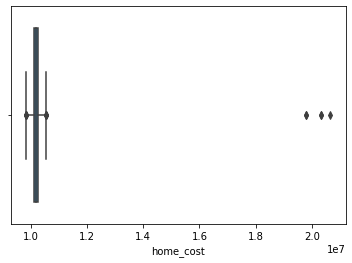

In [5]:
import seaborn as sns
sns.boxplot(x=df['home_cost'])

# функция для нахождения выбросов по Q1 и Q3 
def outliers_iqr(q):
    quartile_1, quartile_3 = np.percentile(q, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((q > upper_bound) | (q < lower_bound))

outliers=outliers_iqr(df['home_cost'])


# Убираем выбросы
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out


df = remove_outlier(df, 'home_cost')
df 

Гистограмма отображает частоту (количество) числовой переменной, разбивая ее на ячейки (интервалы). 
Чтобы помочь определить разумную ширину бина, мы можем использовать правило Фридмана-Диакониса, которое было разработано для минимизации разницы между площадью под эмпирическим распределением вероятностей и площадью под теоретическим распределением вероятностей. Формально правило принимает в качестве входных данных межквартильный диапазон IQR(x) и количество наблюдений n в наборе эмпирических данных и возвращает оценку ширины бина.

In [6]:
x=df['salary']
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
#plt.hist(x, bins=bins);

Freedman–Diaconis number of bins: 21


Гипотеза: 
1. Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?

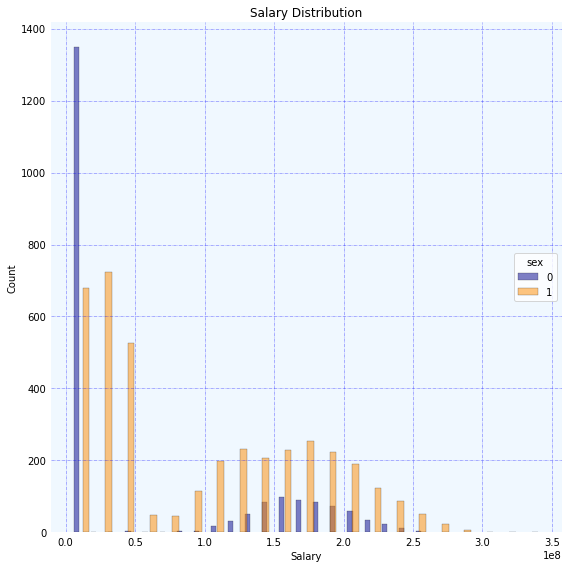

In [7]:
import matplotlib.pyplot as plt
A = df.loc[df['sex'] == 0]  # женский пол 
B = df.loc[df['sex'] == 1]  # мужской пол  

fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Убираем x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Добавим padding между axes and labels
axs.xaxis.set_tick_params(pad = 1)
axs.yaxis.set_tick_params(pad = 1)
 
# Добавим клеточки 
axs.grid(visible = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

#Фоновый цвет 
axs.set_facecolor('aliceblue')
 

#Добавим гистограмму bins=21 по Freedman–Diaconis
plt.hist(A['salary'], alpha=0.5, label='0', color="darkblue", histtype='barstacked', bins=21, edgecolor="black", linewidth=0.4, rwidth=0.3)
plt.hist(B['salary'], alpha=0.5, label='1', color ="darkorange", histtype='barstacked', bins=21, edgecolor='black', linewidth=0.4, rwidth=0.3)



#Довавляем титул, и название осей 
plt.title('Salary Distribution')
plt.xlabel('Salary')
plt.ylabel('Count')

# 
legend = plt.legend(loc = "center right")
legend.set_title("sex")
#Нарисуем гистограмму 
plt.show()


In [8]:
# Проверем гипотезу
# Из данных: sex - Пол (0 - женщина, 1 - мужчина)

if B['salary'].mean() > A['salary'].mean():
    print('Мужчины в среднем имеют более высокую зарплату')
else:
    print('Женщины в среднем имеют более высокую зарплату')

Мужчины в среднем имеют более высокую зарплату


Гипотеза: 
1. Правда ли женщины в среднем имеют более высокую зарплату, чем мужчины?
   Ответ: Нет не правда, Мужчины в среднем имеют более высокую зарплату

2. Правда ли, что инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?
   Ответ: Нет, инженеры (Engineer) не зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?

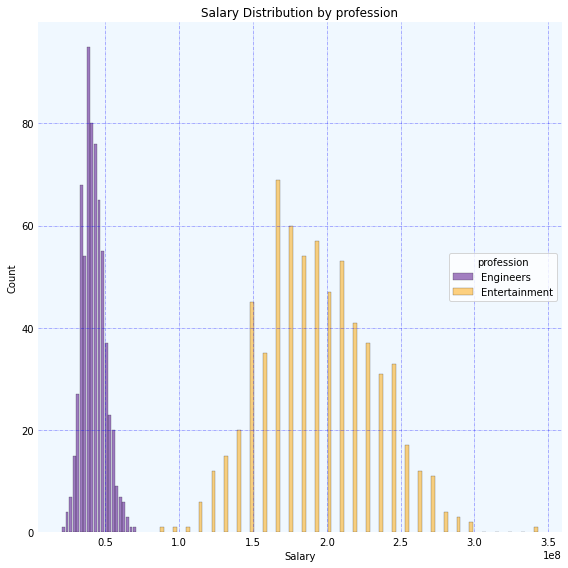

In [9]:
Engineers = df.loc[df['profession'] == 'Engineer']
Entainer = df.loc[df['profession'] == 'Entertainment']

fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 1)
axs.yaxis.set_tick_params(pad = 1)
 
# Add x, y gridlines
axs.grid(visible = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.set_facecolor('aliceblue')


#add three histograms to one plot
plt.hist(Engineers['salary'], alpha=0.5, label='Engineers', color="indigo", histtype='barstacked', bins=21, edgecolor="black", linewidth=0.4, rwidth=0.8)
plt.hist(Entainer['salary'], alpha=0.5, label='Entertainment', color="orange", histtype='barstacked', bins=30, edgecolor="black", linewidth=0.4, rwidth=0.3)



#add plot title and axis labels
plt.title('Salary Distribution by profession')
plt.xlabel('Salary')
plt.ylabel('Count')

legend = plt.legend(loc = "center right")
legend.set_title("profession")

#plt.legend()
#display plot
plt.show()


In [10]:
if Engineers['salary'].mean() > Entainer['salary'].mean():
    print('Да, инженеры (Engineer) зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?')
else:
    print('Нет, инженеры (Engineer) не зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?')
    

Нет, инженеры (Engineer) не зарабатывают в среднем больше, чем люди из сферы развлечений (Entertainment)?


3. Правда ли, что те, у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?
   Ответ: Да, те у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей

Text(0, 0.5, 'Count')

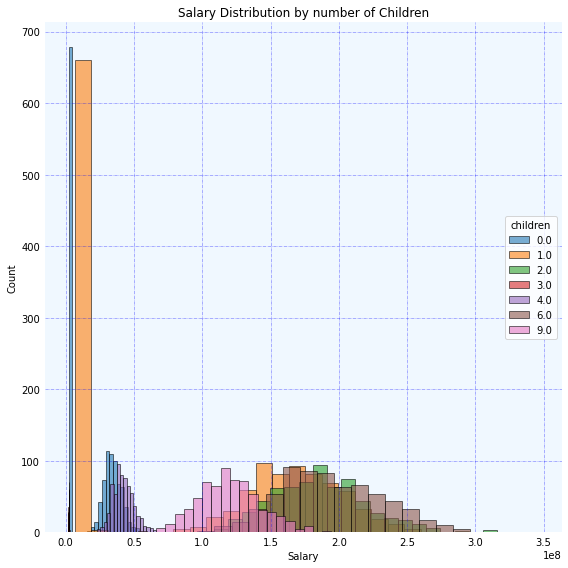

In [11]:
fig, axs = plt.subplots(figsize=(8, 8), tight_layout=True)
for s in ['top', 'bottom', 'left', 'right']:
    axs.spines[s].set_visible(False)

# Remove x, y ticks
axs.xaxis.set_ticks_position('none')
axs.yaxis.set_ticks_position('none')
   
# Add padding between axes and labels
axs.xaxis.set_tick_params(pad = 1)
axs.yaxis.set_tick_params(pad = 1)
 
# Add x, y gridlines
axs.grid(visible = True, color ='blue',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.6)

axs.set_facecolor('aliceblue')
 

df.groupby('children')['salary'].hist( histtype='barstacked', alpha = 0.6, legend=True, bins=21, edgecolor="black", linewidth=0.9, rwidth=1)
#vc = df.groupby('children')['salary']
#colors = ['aqua', 'red', 'gold', 'royalblue', 'darkorange', 'green', 'purple', 'steelblue']

legend = plt.legend(loc = "center right")
legend.set_title("children")

plt.title('Salary Distribution by number of Children')
plt.xlabel('Salary')
plt.ylabel('Count')


In [12]:
C = df.loc[df['children'] > 3]
D = df.loc[df['sex'] <= 3]
if C['salary'].mean() > D['salary'].mean():
    print('Да, те у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей')
else:
    print('Нет не правда')

Да, те у кого больше трех детей зарабатывают в среднем больше, чем те, у кого меньше или трое детей?


4. Правда ли, что дома художники (Artist) живут в домах, которые в среднем дороже или дешевле, чем дома адвокатов (Lawyer)?
   Ответ: Нет, не правда, дома адвокатов(Lawyer) живут в домах, которые в среднем дороже чем дома художники (Artist) (из графика)

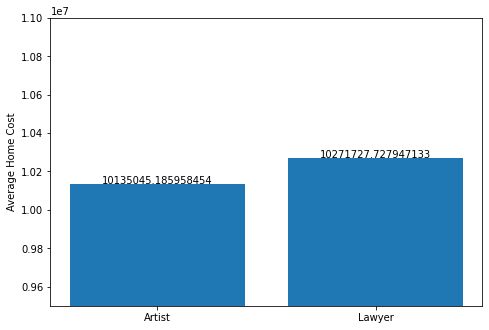

In [13]:
Artist = df.loc[df['profession'] == 'Artist']
Lawyer = df.loc[df['profession'] == 'Lawyer']

# функция 
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], y[i], ha = 'center')
fig = plt.figure()

ax = fig.add_axes([0,0,1,1])
profession = ['Artist', 'Lawyer']

#Средняя цена для разных профессий
homecost = [Engineers['home_cost'].mean(),Lawyer['home_cost'].mean()]
ax.bar(profession ,homecost)
addlabels(profession ,homecost)
      
plt.ylim([9500000, 11000000])

plt.ylabel("Average Home Cost")
plt.show()

5. Прада ли, что недвижимость у бывавших в браке в среднем дороже, чем у не бывавших в браке?
   Ответ: как видим из графика недвижимость у single больше чем у married, значит гипотеза не верна. Недвижимость у бывавших в браке в среднем дешевле, чем у не бывавших в браке

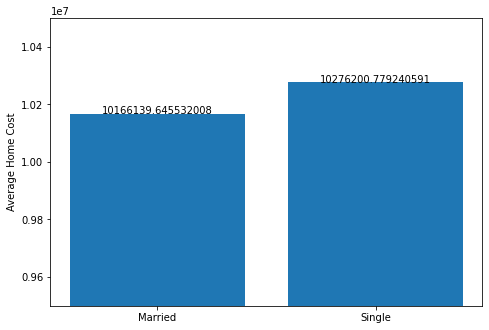

In [14]:
# was married из датасета, обозначаем: 
Single = df.loc[df['was_married'] == 0]
Married = df.loc[df['was_married'] == 1]

# Выведем график 
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Status = ['Married', 'Single']
HC = [Married['home_cost'].mean(),Single['home_cost'].mean()]
ax.bar(Status ,HC)
addlabels(Status ,HC)
      
plt.ylim([9500000, 10500000])

plt.ylabel("Average Home Cost")
plt.show()

Прада ли, что мужчины в среднем чаще бывают в браке, чем женщины?
Подсказка - воспользуйтесь критерием хи-квадрат из библиотеки scipy

Критерий хи-квадрат - статистический критерий для проверки гипотезы  H_0, что наблюдаемая случайная величина подчиняется некому теоретическому закону распределения.

Ответ: Гипотеза ложна по критерию хи-квадрат, гипотеза ложна что мужчины в среднем чаще бывают в браке, чем женщины

In [27]:
# Определим дата, sex = 0, and was married = 0
# sex = 0 and was married = 1
# sex = 1 and was married = 1
# sex =1 and was married = 0 




len(df.loc[df['sex'] == 0].loc[df['was_married'] == 0])
data = [[len(df.loc[df['sex'] == 0].loc[df['was_married'] == 0]), 
         len(df.loc[df['sex'] == 0].loc[df['was_married'] == 1])],
             [len(df.loc[df['sex'] == 1].loc[df['was_married'] == 0]), 
              len(df.loc[df['sex'] == 1].loc[df['was_married'] == 1])]]



# подсчитаем p-value, 0.05 significance level 
# Статистически значимый результат теста (P ≤ 0,05) означает, что гипотеза теста ложна 
# или должна быть отклонена. Значение P больше 0,05 означает, 
# что никакого эффекта не наблюдалось.

from scipy.stats import chi2_contingency
stat, p, dof, expected = chi2_contingency(data)

alpha = 0.05
print("p value is " + str(p))
if p <= alpha:
    print('гипотеза теста ложна и должна быть отклонена')
else:
    print('Значение P больше 0,05 означает, что никакого эффекта не наблюдалось.')



p value is 4.251314801963343e-150
гипотеза теста ложна и должна быть отклонена


Гипотезы при множественном тестировании (10 баллов)


Правда ли между представителями таких профессий как, Homemaker, Marketing, Healthcare и Executive в среднем зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием.
# Подсказка: 
# - дисперсионнай анализ  f_oneway()
# - Крускал Уоллиса

Определим гипотезы: 
H0: распределения всех выборок равны. - Дано в вопросе 
H1: распределения одной или нескольких выборок не равны.

stat=11359.172, p=0.000
Возможно разное распределние


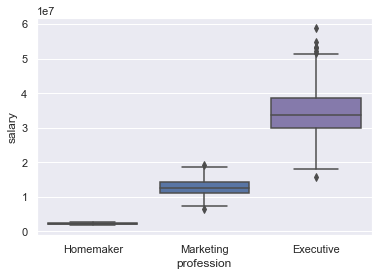

In [42]:
# f-one way 
# Критерий Крускала-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех 
# или более независимых групп.
from scipy.stats import f_oneway, ttest_ind

Homemaker = df.query('profession == "Homemaker"')['salary']
Marketing = df.query('profession == "Marketing"')['salary']
Executive = df.query('profession == "Executive"')['salary']

df.groupby('profession').describe()




indexA = df[ (df['profession'] != 'Homemaker') & (df['profession'] != 'Marketing') 
              & (df['profession'] != 'Executive')].index
a=df.drop(indexA , inplace=False)


#тест Крускала-Уоллиса
# Проверяет, равны ли распределения двух или более независимых выборок.
#print(ttest_ind(Homemaker, Marketing).pvalue) 
#print(ttest_ind(Homemaker, Executive).pvalue)
#print(ttest_ind(Marketing, Executive).pvalue)


#Рисуем boxplot

# настройка цвета 
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .3))
 
sns.set(style="darkgrid")
my_col = {"Homemaker": "g", "Marketing": "b", "Executive":"m"}
sns.boxplot(x='profession', y='salary', data=a,  palette=my_col)

# f-oneway 
stat, p = f_oneway(Homemaker, Marketing, Executive)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
	print('Возможно одинаковое распределение')
else:
	print('Возможно разное распределние')

#Значения р для каждой комбинации меньше уровня значимости альфа (например, 0,05). 
# Это означает, что мы можем заключить, 
# что средняя заработная плата каждой профессии статистически отличается от другой профессии.


Правда ли между представителями таких профессий как, Doctor, Entertainment и Lawyer в среднем зарплаты не отличаются между собой? Ответ подкрепите визуализацией и подходящим статистическим критерием.

p-value: Doctor: 9.593251661014976e-20
p-value: Lawyer: 2.6419655196268494e-36
p-value: Entertainment: 5.8202223982795625e-05


<AxesSubplot: xlabel='profession', ylabel='salary'>

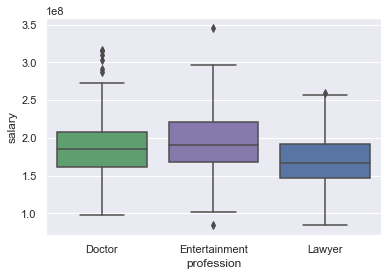

In [46]:
# f-one way 
# Критерий Крускала-Уоллиса используется для определения наличия статистически значимой разницы между медианами трех 
# или более независимых групп.
from scipy.stats import f_oneway, ttest_ind

Lawyer = df.query('profession == "Lawyer"')['salary']
Doctor = df.query('profession == "Doctor"')['salary']
Entertainment = df.query('profession == "Entertainment"')['salary']

#df.groupby('profession').describe()




indexA = df[ (df['profession'] != 'Lawyer') & (df['profession'] != 'Entertainment') 
              & (df['profession'] != 'Doctor')].index
a=df.drop(indexA , inplace=False)


#тест Крускала-Уоллиса
# Проверяет, равны ли распределения двух или более независимых выборок.
print('p-value: Doctor: ' + str(ttest_ind(Doctor, Lawyer).pvalue)) 
print('p-value: Lawyer: ' + str(ttest_ind(Lawyer, Entertainment).pvalue))
print('p-value: Entertainment: ' + str(ttest_ind(Entertainment, Doctor).pvalue))


#Рисуем boxplot

# adding transparency to colors
for patch in ax.artists:
 r, g, b, a = patch.get_facecolor()
 patch.set_facecolor((r, g, b, .3))
 
sns.set(style="darkgrid")
my_col = {"Doctor": "g", "Lawyer": "b", "Entertainment":"m"}
sns.boxplot(x='profession', y='salary', data=a,  palette=my_col)


#Значения р для каждой комбинации меньше уровня значимости альфа (например, 0,05). 
# Это означает, что мы можем заключить, 
# что средняя заработная плата каждой профессии статистически отличается от другой профессии.


Регрессионный Анализ (20 баллов)
Взглянем от чего зависит уровень счастья

Постройте регрессионную модель зависимости уровня счастья от приведенных факторов (was_married, children, salary, sex, age, home_cost)